In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import date
plt.style.use('fivethirtyeight')
yf.pdr_override()

In [68]:
def get_data(stocks ,start, end, period="1d", interval='1d'):
    data = web.get_data_yahoo(stocks, start = start,end= end,  interval=interval)
    return data

In [69]:
#Data collection
stocks = ['^GSPC']
startdate = date(2020,1,1)
end_date =  date.today()
data = get_data(stocks, startdate, end_date, "1d", "1d")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,3244.669922,3258.139893,3235.530029,3257.850098,3257.850098,3459930000
2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3234.850098,3484700000
2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3702460000
2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3435910000
2020-01-08,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3726840000
...,...,...,...,...,...,...
2023-02-03,4136.689941,4182.359863,4123.359863,4136.479980,4136.479980,4694510000
2023-02-06,4119.569824,4124.629883,4093.379883,4111.080078,4111.080078,4114240000
2023-02-07,4105.350098,4176.540039,4088.389893,4164.000000,4164.000000,4355860000


# Strategy using SMA
SMA - Average of the Close Prices for a certain period to smoothen the trend & depict the general direction of the trend flow.

Strategy Description:
 - Two sma one for a short period while the other is for a long period.
 - Buy when the Short MA is more than the long one 
 - Sell when the Long MA is more than the Short one. 
 - Two lists named signalBuy and signalSell;
 - whenever the Buy condition was meeting, append the Close Price to the list; else, append NaN to stored the same lists in our data. By having a variable named position, which ensures that to take opposite trade after the previous trade, so if the previous trade was 'buy', then the next trade will only be 'sell' as the position is set to true.

In [70]:
sma_data = data.copy()
sma_data['SMA 30'] = ta.sma(sma_data['Close'],3)
sma_data['SMA 100'] = ta.sma(sma_data['Close'],10)

def buy_sell(df):
    signalBuy = []
    signalSell = []
    position = False 

    for i in range(len(df)):
        if df['SMA 30'][i] > df['SMA 100'][i]:
            if position == False :
                signalBuy.append(df['Adj Close'][i])
                signalSell.append(np.nan)
                position = True
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        elif df['SMA 30'][i] < df['SMA 100'][i]:
            if position == True:
                signalBuy.append(np.nan)
                signalSell.append(df['Adj Close'][i])
                position = False
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        else:
            signalBuy.append(np.nan)
            signalSell.append(np.nan)
    return pd.Series([signalBuy, signalSell])
sma_data['Buy_Signal_price'], sma_data['Sell_Signal_price'] = buy_sell(sma_data)

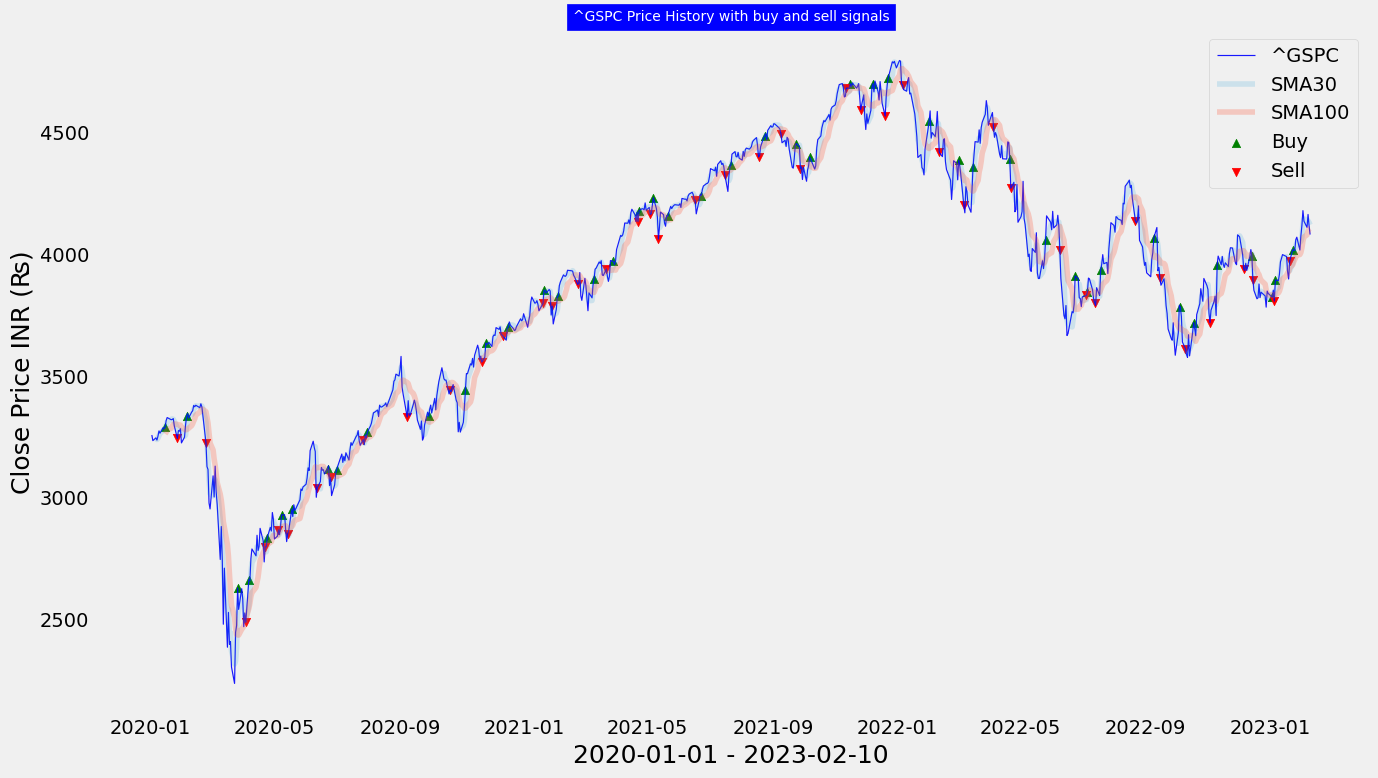

In [71]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(sma_data['Adj Close'] , label = stocks[0] ,linewidth=0.85, color='blue', alpha = 0.9)
ax.plot(sma_data['SMA 30'], label = 'SMA30', alpha = 0.15)
ax.plot(sma_data['SMA 100'], label = 'SMA100' , alpha = 0.25)
ax.scatter(sma_data.index , sma_data['Buy_Signal_price'] , label = 'Buy' , marker = '^', color = 'green',alpha =1 )
ax.scatter(sma_data.index , sma_data['Sell_Signal_price'] , label = 'Sell' , marker = 'v', color = 'red',alpha =1 )
ax.set_title(stocks[0] + " Price History with buy and sell signals",fontsize=10, backgroundcolor='blue', color='white')
ax.set_xlabel(f'{startdate} - {end_date}' ,fontsize=18)
ax.set_ylabel('Close Price INR (₨)' , fontsize=18)
legend = ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

# Strategy using MACD

MACD: The Moving Average Convergence Divergence indicator (MACD) is calculated using two exponential moving averages (EMA) - short term and long term. An exponential moving average of MACD is used as a signal line to indicate the upward or downward momentum. An exponential moving average is nothing but simply a moving average that gives more weightage to the recent data.

By calculating the MACD with pandas-ta; it'll give us three columns, one is of the difference between the two EMA's called MACD and one is the EMA of MACD value called as Signal, and the last one is the difference between MACD & Signal called as MACD histogram. 

In [72]:
macd_data = data.copy()
macd = ta.macd(macd_data['Close'])
macd_data = pd.concat([macd_data, macd], axis=1).reindex(macd_data.index)

In [73]:
def MACD_Strategy(df, risk):
    MACD_Buy=[]
    MACD_Sell=[]
    position=False

    for i in range(0, len(df)):
        if df['MACD_12_26_9'][i] > df['MACDs_12_26_9'][i] :
            MACD_Sell.append(np.nan)
            if position ==False:
                MACD_Buy.append(df['Adj Close'][i])
                position=True
            else:
                MACD_Buy.append(np.nan)
        elif df['MACD_12_26_9'][i] < df['MACDs_12_26_9'][i] :
            MACD_Buy.append(np.nan)
            if position == True:
                MACD_Sell.append(df['Adj Close'][i])
                position=False
            else:
                MACD_Sell.append(np.nan)
        elif position == True and df['Adj Close'][i] < MACD_Buy[-1] * (1 - risk):
            MACD_Sell.append(df["Adj Close"][i])
            MACD_Buy.append(np.nan)
            position = False
        elif position == True and df['Adj Close'][i] < df['Adj Close'][i - 1] * (1 - risk):
            MACD_Sell.append(df["Adj Close"][i])
            MACD_Buy.append(np.nan)
            position = False
        else:
            MACD_Buy.append(np.nan)
            MACD_Sell.append(np.nan)

    df['MACD_Buy_Signal_price'] = MACD_Buy
    df['MACD_Sell_Signal_price'] = MACD_Sell
    return df




For now, Risk tolerance level to 2.5%, For Example, if we buy at 100 and the price goes beyond 97.5 (100 (1 - 0.025)), we'll sell. We'll trail our stop loss, which means that if we buy at 100 and the price goes to 110, our stop loss will be 107.25 (110 (1 - 0.025)).

In [74]:
MACD_strategy = MACD_Strategy(macd_data, 0.05)

#For better visualization
def MACD_color(data):
    MACD_color = []
    for i in range(0, len(data)):
        if data['MACDh_12_26_9'][i] > data['MACDh_12_26_9'][i - 1]:
            MACD_color.append(True)
        else:
            MACD_color.append(False)
    return MACD_color

macd_data['positive'] = MACD_color(macd_data)


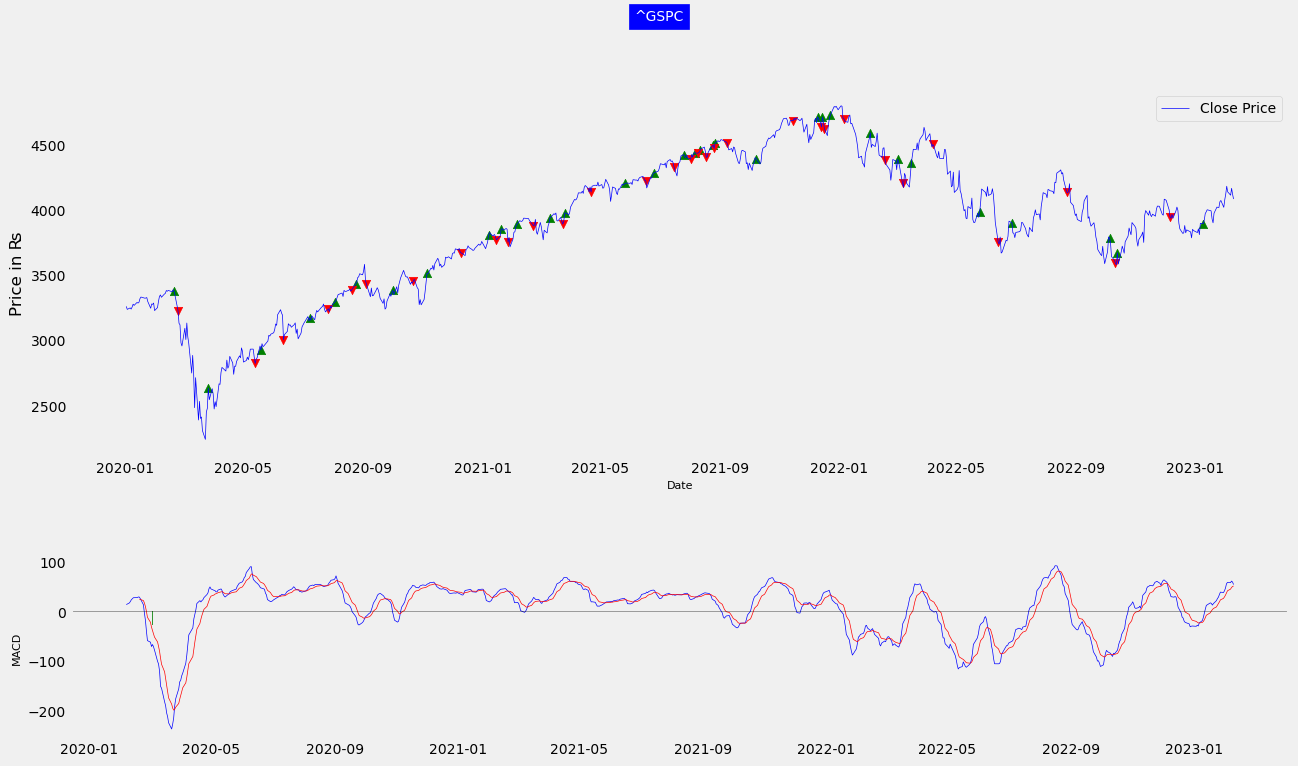

In [75]:
plt.rcParams.update({'font.size': 10})
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle(stocks[0], fontsize=10, backgroundcolor='blue', color='white')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price in ₨')
ax1.plot('Adj Close',data=macd_data, label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(data.index, macd_data['MACD_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(data.index, macd_data['MACD_Sell_Signal_price'], color='red', marker='v', alpha=1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)

ax2.set_ylabel('MACD', fontsize=8)
ax2.plot('MACD_12_26_9', data=macd_data, label='MACD', linewidth=0.5, color='blue')
ax2.plot('MACDs_12_26_9', data=macd_data, label='signal', linewidth=0.5, color='red')
ax2.bar(data.index,'MACDh_12_26_9', data=macd_data, label='Volume', color=macd_data.positive.map({True: 'g', False: 'r'}),width=0.001,alpha=0.8)
ax2.axhline(0, color='black', linewidth=0.5, alpha=0.5)
ax2.grid()
plt.show()

# Strategy using Bollinger band
BB: Bollinger bands are one of the most used indicators in the world of trading, simply because it is so powerful and yet very simple.They comprise of three lines,Upper Bollinger band, Middle Bollinger band, Lower Bollinger band. 

The upper and lower Bollinger bands are plotted two standard deviations away from the mean average of the Close Price. 
The two bands comprise more than 80% of the price action, thus making any price above or below the bands highly significant.

#### **Strategy used in this example**
 
 Any time the closing price goes below or above the Bollinger bands, there are high chances for price reversion, and hence it can be used as a signal but can't be entirely relied upon as there might be an underlying event driving the stock.

In [76]:
def bb_strategy(df):
    bbBuy = []
    bbSell = []
    position = False
    bb = ta.bbands(df['Adj Close'], length=20,std=2)
    df = pd.concat([df, bb], axis=1).reindex(df.index)

    for i in range(len(df)):
        if df['Adj Close'][i] < df['BBL_20_2.0'][i]:
            if position == False :
                bbBuy.append(df['Adj Close'][i])
                bbSell.append(np.nan)
                position = True
            else:
                bbBuy.append(np.nan)
                bbSell.append(np.nan)
        elif df['Adj Close'][i] > df['BBU_20_2.0'][i]:
            if position == True:
                bbBuy.append(np.nan)
                bbSell.append(df['Adj Close'][i])
                position = False #To indicate that I actually went there
            else:
                bbBuy.append(np.nan)
                bbSell.append(np.nan)
        else :
            bbBuy.append(np.nan)
            bbSell.append(np.nan)

    df['bb_Buy_Signal_price'] = bbBuy
    df['bb_Sell_Signal_price'] = bbSell

    return df

bb_data = data.copy()
bb_data = bb_strategy(bb_data)

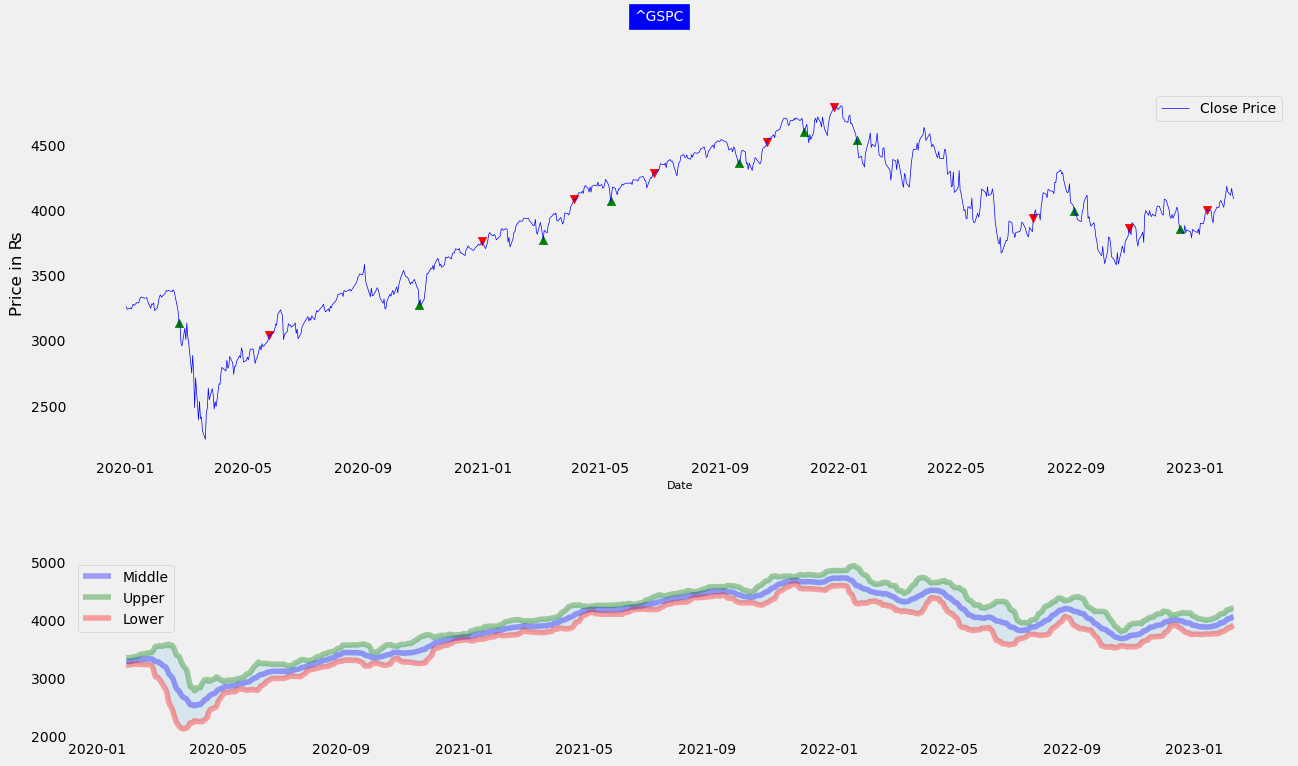

In [77]:
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle(stocks[0], fontsize=10, backgroundcolor='blue', color='white')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price in ₨')
ax1.plot(bb_data['Adj Close'],label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(bb_data.index, bb_data['bb_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(bb_data.index, bb_data['bb_Sell_Signal_price'], color='red', marker='v', alpha=1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)

ax2.plot(bb_data['BBM_20_2.0'], label='Middle', color='blue', alpha=0.35) #middle band
ax2.plot(bb_data['BBU_20_2.0'], label='Upper', color='green', alpha=0.35) #Upper band
ax2.plot(bb_data['BBL_20_2.0'], label='Lower', color='red', alpha=0.35) #lower band
ax2.fill_between(bb_data.index, bb_data['BBL_20_2.0'], bb_data['BBU_20_2.0'], alpha=0.1)
ax2.legend(loc='upper left')
ax2.grid()
plt.show()
